# Importing the required libraries

In [ ]:
import networkx as nx
import random
import math
import csv
import datetime
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/dmdw_project

/content/drive/MyDrive/dmdw_project


# EDA

# Reading the data file

In [ ]:
df = pd.read_csv('facebook_combined.txt', sep='\t')
df

,0 1
0,0 2
1,0 3
2,0 4
3,0 5
4,0 6
...,...
88228,4026 4030
88229,4027 4031
88230,4027 4032
88231,4027 4038


# Plotting the network graph of the dataset

In [ ]:
def create_graph_from_file(filename):
    print("----------------building graph--------------------")
    f = open(filename, "rb")
    g = nx.read_edgelist(f)
    return g

----------------building graph--------------------


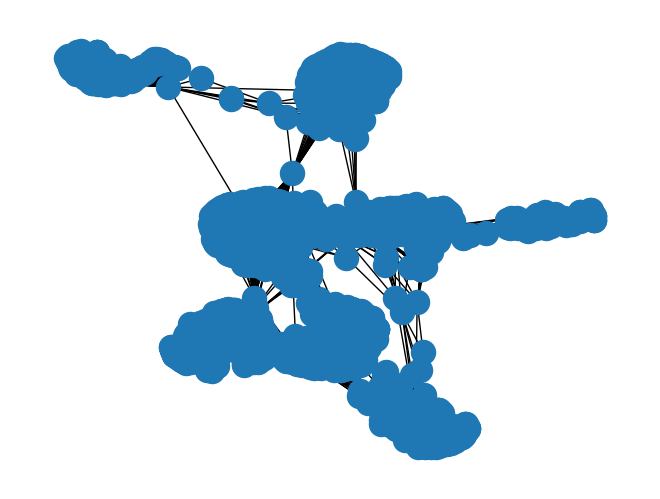

In [ ]:
digraph = create_graph_from_file('facebook_combined.txt')
nx.draw(digraph)
plt.show()
digraph=digraph.to_directed()

# Nodes and Edges in the graph

In [ ]:
print(digraph)
type(digraph)

DiGraph with 4039 nodes and 176468 edges


networkx.classes.digraph.DiGraph

# No of followers of each person

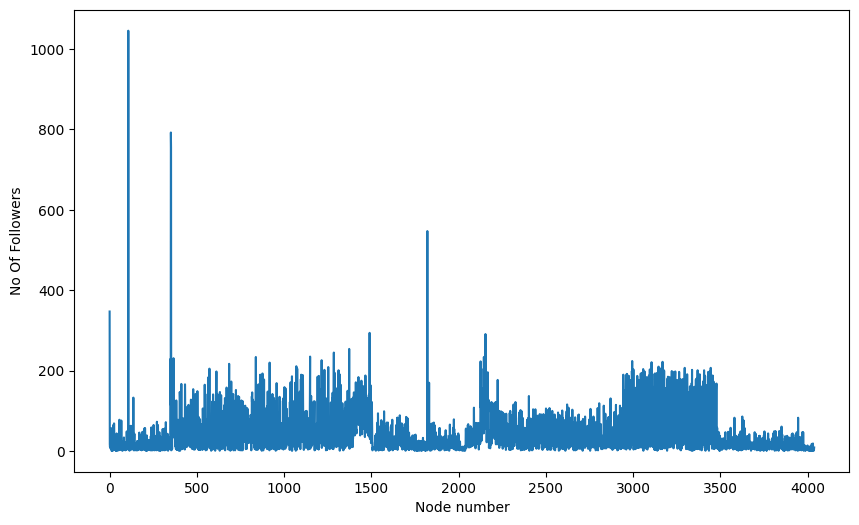

Node :  107 , Followers :  1045


In [ ]:
indegree_dist = list(dict(digraph.in_degree()).values())
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Node number')
plt.ylabel('No Of Followers')
plt.show()
print("Node : " , indegree_dist.index(max(indegree_dist)),", Followers : ", max(indegree_dist))

# No of people each person is following

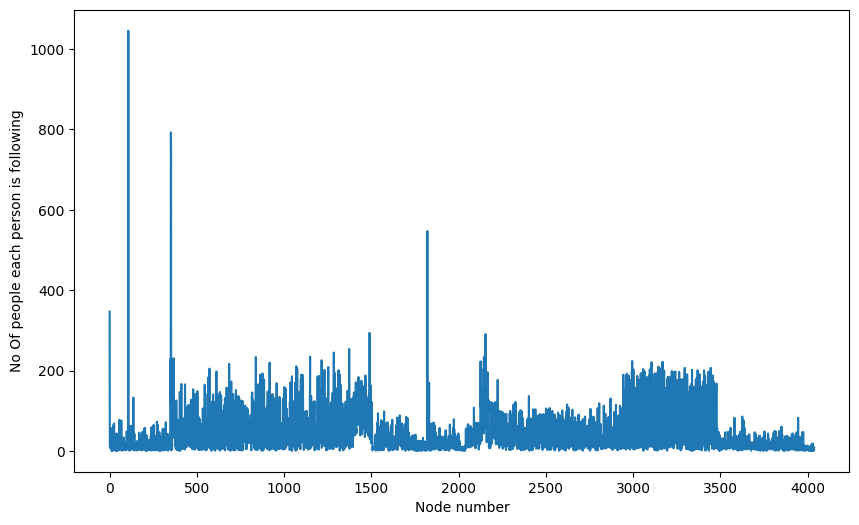

In [ ]:
outdegree_dist = list(dict(digraph.out_degree()).values())
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Node number')
plt.ylabel('No Of people each person is following')
plt.show()

# Creating false edges for supervised learning

In [ ]:
def produce_fake_edge(g, neg_g, num_test_edges):
    i = 0
    while i < num_test_edges:
        edge = random.sample(g.nodes(), 2)  # choosing 2 random nodes from all nodes
        try:
            shortest_path = nx.shortest_path_length(g,source=edge[0],target=edge[1])
            if shortest_path >= 2:  # require path length to be atleast 2 because path length 1 means direct true edge and not false edge
                neg_g.add_edge(edge[0],edge[1], positive="False")
                i += 1
        except:
            pass

# Similarity Based Techniques

# Common Neighbours

\begin{equation}
Common Neighbours = {N(x)\cap N(y)}
\end{equation}

In [ ]:
def CommonNeighbors(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))

def common_neighbors(g, edges):
    result = []
    for edge in edges:
        node_one, node_two = edge[0], edge[1]
        num_common_neighbors = 0
        try:
            neighbors_one, neighbors_two = g.neighbors(node_one), g.neighbors(node_two)
            for neighbor in neighbors_one:
                if neighbor in neighbors_two:
                    num_common_neighbors += 1
            result.append((node_one, node_two, num_common_neighbors))
        except:
            pass
    return result

# Jaccard Coefficient

\begin{equation}
j = \frac{|N(x)\cap N(y)|}{|N(x) \cup N(y)|}
\end{equation}

In [ ]:
def JaccardCoefficent(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

# Resource Allocation

\begin{equation}
Resource Allocation = \displaystyle\sum_{u\in N(x)\cap N(y)} \frac{1}{|N(u)|}
\end{equation}

In [ ]:
def ResourceAllocation(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    ra = 0
    for i in u_neighbors.intersection(v_neighbors): # for each common neighbour of u and v
        ra += 1 / float(len(g.neighbors(i)))
    return ra

# Adamic Adar Index

\begin{equation}
A = \displaystyle\sum_{u\in N(x)\cap N(y)} \frac{1}{log|N(u)|}
\end{equation}

In [ ]:
def AdamicAdar(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    adamicAdarIndex = 0
    for i in u_neighbors.intersection(v_neighbors):  # for each common neighbour of u and v
        adamicAdarIndex += 1 / math.log(len(g.neighbors(i)))
    return adamicAdarIndex

# Preferential Attachment

\begin{equation}
Preferential Attachment = {|N(x)||N(y)|}
\end{equation}

In [ ]:
def PreferentialAttachment(u, v, g):
    return len(g.neighbors(u))*len(g.neighbors(v))

# All the features combined

In [ ]:
def AllFeatures(u,v, g1, g2):
    try:
        cn = CommonNeighbors(u, v, g2)
        aa = AdamicAdar(u, v, g2)
        ra = ResourceAllocation(u, v, g2)
        jc = JaccardCoefficent(u, v, g2)
        pa = PreferentialAttachment(u, v, g2)

        delta_cn = cn - CommonNeighbors(u, v, g1)
        delta_aa = aa - AdamicAdar(u, v, g1)
        delta_ra = ra - ResourceAllocation(u, v, g1)
        delta_jc = jc - JaccardCoefficent(u, v, g1)
        delta_pa = pa - PreferentialAttachment(u, v, g1)
        return {"cn":cn, "aa": aa, "ra":ra, "jc":jc, "pa":pa,
            "delta_cn": delta_cn, "delta_aa": delta_aa, "delta_ra": delta_ra,
             "delta_jc": delta_jc, "delta_pa": delta_pa}
    except:
        pass

# Expanded feature set

In [ ]:
feature_set = [common_neighbors,nx.resource_allocation_index,
               nx.jaccard_coefficient,nx.adamic_adar_index,
               nx.preferential_attachment]

# Separating the postive and negative edges for testing dataset

In [ ]:
def sample_extraction(g, pos_num, neg_num, neg_mode):
    """

    :param g:  the graph
    :param pos_num: the number of positive samples
    :param neg_num: the number of negative samples
    :return: pos_sample is a list of positive edges, neg_sample is a list of negative edges
    """

    print("----------------extract positive samples--------------------")
    # randomly select pos_num as test edges
    pos_sample = random.sample(g.edges(), pos_num)
    sample_g = nx.Graph()
    sample_g.add_edges_from(pos_sample, positive="True")
    nx.write_edgelist(sample_g, "sample_positive_" +str(pos_num)+ ".txt", data=['positive'])

    # adding non-existing edges
    print("----------------extract negative samples--------------------")
    i = 0
    neg_g = nx.Graph()
    produce_fake_edge(g,neg_g,neg_num)
    nx.write_edgelist(neg_g, "sample_negative_" +str(neg_num)+ ".txt", data=["positive"])
    neg_sample = neg_g.edges()
    neg_g.add_edges_from(pos_sample,positive="True")
    nx.write_edgelist(neg_g, "sample_combine_" +str(pos_num + neg_num)+ ".txt", data=["positive"])

    return pos_sample, neg_sample

# Feature expansion for each pair of nodes

In [ ]:
def feature_extraction(g, pos_sample, neg_sample, feature_name, model="single"):
    data = []
    label = ["label"] + ["1" for i in range(len(pos_sample))] + ["0" for i in range(len(neg_sample))]
    for j in feature_name:
        print ("-----extract feature:", j.__name__, "----------")
        preds = j(g, pos_sample)
        feature = [j.__name__] + [i[2] for i in preds]
        preds = j(g, neg_sample)
        feature = feature + [i[2] for i in preds]
        data.append(feature)

    data.append(label)
    data = transpose(data)
    print("----------write the features to file---------------")
    write_data_to_file(data, "features_" + model + "_" + ".csv")
    return data


def write_data_to_file(data, filename):
    csvfile = open(filename, "w")
    writer = csv.writer(csvfile)
    for i in data:
        writer.writerow(i)
    csvfile.close()


def transpose(data):
    return [list(i) for i in zip(*data)]

# Main function

In [ ]:
def main(filename, model,feature_name, neg_mode, pos_num=0.008, neg_num=0.008):
    g = create_graph_from_file(filename)
    num_edges = g.number_of_edges()
    pos_num = int(num_edges * pos_num)
    neg_num = int(num_edges * neg_num)
    pos_sample, neg_sample = sample_extraction(g, pos_num, neg_num,neg_mode)
    train_data = feature_extraction(g, pos_sample, neg_sample, feature_name, model)


In [ ]:
#Run this line to genrate feature Set
main(filename="facebook_combined.txt",model="combined",feature_name=feature_set, neg_mode="easy")

----------------building graph--------------------
----------------extract positive samples--------------------
----------------extract negative samples--------------------
-----extract feature: common_neighbors ----------
-----extract feature: resource_allocation_index ----------
-----extract feature: jaccard_coefficient ----------
-----extract feature: adamic_adar_index ----------
-----extract feature: preferential_attachment ----------
----------write the features to file---------------


In [ ]:
df=pd.read_csv('features_combined_.csv', sep=',')
df.head()

,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
0,0,0.653051,0.382353,11.655572,7611,1
1,1,0.109540,0.105263,1.434998,902,1
2,6,0.658889,0.396694,11.108621,6634,1
3,1,0.269779,0.160377,4.017787,2660,1
4,0,0.484412,0.321429,8.253637,5460,1


In [ ]:
r=np.loadtxt(open("features_combined_"+".csv", "rb"), delimiter=",", skiprows=1);
r.shape
l,b=r.shape;

In [ ]:
np.random.shuffle(r);

# Train & Test split in ratio 75:25

In [ ]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]

# Normalizing the train and test datasets for various features

In [ ]:
from sklearn.preprocessing import normalize, StandardScaler
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Classification through ML models

# SVM

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
def mySvm(training, training_labels, testing, testing_labels):
    #Support Vector Machine
    clf = svm.SVC()
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the SVM classifier ++++++++++++")
    result = clf.predict(testing)

    print ("SVM accuracy:", accuracy_score(testing_labels, result))
    return result

In [ ]:
#Run this to for SVM classification
result=mySvm(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the SVM classifier ++++++++++++
SVM accuracy: 0.6483931947069943


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def logistic(training, training_labels, testing, testing_labels):
    clf = LogisticRegression().fit(training, training_labels)
    clf.fit(training, training_labels)
    result=clf.predict(testing)
    print ("+++++++++ Finishing training the Linear classifier ++++++++++++")
    print ("Linear accuracy:", accuracy_score(testing_labels, result))
    return result

In [ ]:
#Run this for Logistic Regression
result=logistic(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the Linear classifier ++++++++++++
Linear accuracy: 0.6843100189035917


# ANN

In [ ]:
from sklearn.neural_network import MLPClassifier
def ANN(training, training_labels, testing, testing_labels):
    clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,9), random_state=1)
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the ANN classifier ++++++++++++")
    result = clf.predict(testing)
    print ("ANN accuracy:", accuracy_score(testing_labels, result))

In [ ]:
# Run this for ANN classification
ANN(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the ANN classifier ++++++++++++
ANN accuracy: 0.6616257088846881
